# Imputing Data

When a dataset has missing values, you can either remove those values or fill them in. In this exercise, you'll work with World Bank GDP (Gross Domestic Product) data to fill in missing values.

In [1]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('../data/gdp_data.csv', skiprows=4)
df.drop('Unnamed: 62', axis=1, inplace=True)

In [4]:
# run this code cell to see what the data looks like
df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.791961e+09,2.498933e+09,2.467704e+09,2.584464e+09,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,...,1.019053e+10,1.248694e+10,1.593680e+10,1.793024e+10,2.053654e+10,2.026425e+10,2.061610e+10,1.921556e+10,1.946902e+10,2.081530e+10
2,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,8.417804e+10,7.549239e+10,8.252614e+10,1.041158e+11,1.139232e+11,1.249125e+11,1.267302e+11,1.026212e+11,9.533720e+10,1.242094e+11
3,Albania,ALB,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.288135e+10,1.204421e+10,1.192695e+10,1.289087e+10,1.231978e+10,1.277628e+10,1.322824e+10,1.138693e+10,1.188368e+10,1.303935e+10
4,Andorra,AND,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4.007353e+09,3.660531e+09,3.355695e+09,3.442063e+09,3.164615e+09,3.281585e+09,3.350736e+09,2.811489e+09,2.877312e+09,3.012914e+09


In [6]:
# Run this code cell to check how many null values are in the data set
df.isnull().sum() / df.shape[0]

Country Name      0.000000
Country Code      0.000000
Indicator Name    0.000000
Indicator Code    0.000000
1960              0.530303
                    ...   
2013              0.060606
2014              0.064394
2015              0.068182
2016              0.087121
2017              0.113636
Length: 62, dtype: float64

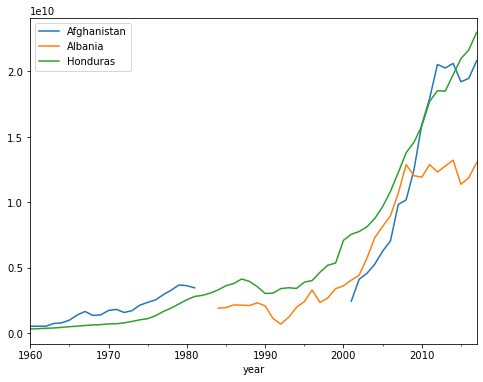

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# put the data set into long form instead of wide
df_melt = pd.melt(df, id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], var_name='year', value_name='GDP')

# convert year to a date time
df_melt['year'] = pd.to_datetime(df_melt['year'])

def plot_results(column_name):
    # plot the results for Afghanistan, Albania, and Honduras
    fig, ax = plt.subplots(figsize=(8,6))

    df_melt[(df_melt['Country Name'] == 'Afghanistan') | 
            (df_melt['Country Name'] == 'Albania') | 
            (df_melt['Country Name'] == 'Honduras')].groupby('Country Name').plot('year', column_name, legend=True, ax=ax)
    ax.legend(labels=['Afghanistan', 'Albania', 'Honduras'])
    
plot_results('GDP')

Afghanistan and Albania are missing data, which show up as gaps in the results. 

## Exercise - Part 1

Your first task is to calculate mean GDP for each country and fill in missing values with the country mean. This is a bit tricky to do in pandas. Here are a few links that should be helpful:
* https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.DataFrame.groupby.html
* https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.transform.html
* https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.DataFrame.fillna.html

In [57]:
# TODO: Use the df_melt dataframe and fill in missing values with a country's mean GDP
# If you aren't sure how to do this, 
# look up something like "how to group data and fill in nan values in pandas" in a search engine
# Put the results in a new column called 'GDP_filled'.

# HINT: You can do this with these methods: groupby(), transform(), a lambda function, fillna(), and mean()
#Solution 1
df_melt['GDP_filled'] = df_melt[['Country Name','GDP']].set_index('Country Name')\
    .fillna(df_melt.groupby('Country Name').agg({'GDP':'mean'}).to_dict())['GDP'].values
# Solution 2
df_melt['GDP_filled'] = df_melt.groupby('Country Name')['GDP'].apply(lambda x: x.fillna(x.mean()))

In [55]:
df_melt.groupby('Country Name')['GDP'].apply(lambda x: x.fillna(x.mean()))

0        2.036355e+09
1        5.377778e+08
2        3.847557e+10
3        6.220172e+09
4        1.501056e+09
             ...     
15307    7.128691e+09
15308    1.701070e+10
15309    3.494193e+11
15310    2.580867e+10
15311    1.784582e+10
Name: GDP, Length: 15312, dtype: float64

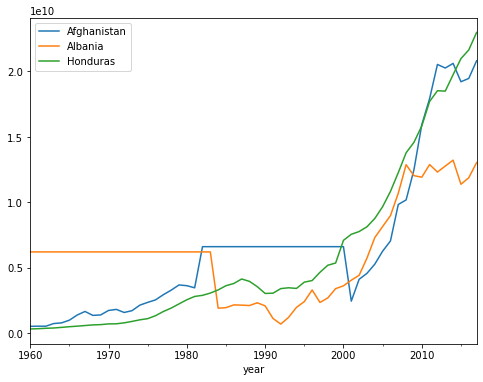

In [58]:
plot_results('GDP_filled')

This is somewhat of an improvement. At least there is no missing data; however, because GDP tends to increase over time, the mean GDP is probably not the best way to fill in missing values for this particular case. Next, try using forward fill to deal with any missing values.

## Excercise - Part 2

Use the fillna forward fill method to fill in the missing data. Here is the [documentation](https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.DataFrame.fillna.html). As explained in the course video, forward fill takes previous values to fill in nulls.

The pandas fillna method has a forward fill option. For example, if you wanted to use forward fill on the GDP dataset, you could execute `df_melt['GDP'].fillna(method='ffill')`. However, there are two issues with that code. 
1. You want to first make sure the data is sorted by year
2. You need to group the data by country name so that the forward fill stays within each country

Write code to first sort the df_melt dataframe by year, then group by 'Country Name', and finally use the forward fill method.

In [68]:
# TODO: Use forward fill to fill in missing GDP values
# HINTS: use the sort_values(), groupby(), and fillna() methods
#Solution 1
df_melt['GDP_ffill'] = df_melt.sort_values('year').groupby('Country Name')['GDP'].apply(lambda x: x.fillna(method='ffill'))
#Solution 2
df_melt['GDP_ffill'] = df_melt.sort_values('year').groupby('Country Name')['GDP'].fillna(method='ffill')

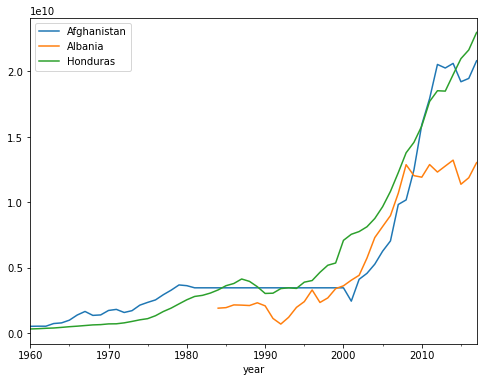

In [69]:
# plot the results
plot_results('GDP_ffill')

This looks better at least for the Afghanistan data; however, the Albania data is still missing values. You can fill in the Albania data using back fill. That is what you'll do next.

## Exercise - Part 3

This part is similar to Part 2, but now you will use backfill. Write code that backfills the missing GDP data.

In [76]:
df_melt.sort_values('year').groupby('Country Name')['GDP'].fillna(method='bfill')

0        1.330168e+09
167      1.916242e+09
168      5.844779e+11
169      2.434885e+09
170      1.595945e+08
             ...     
15141    5.147541e+13
15142    3.414493e+11
15143    2.297853e+10
15129    4.733002e+10
15311    1.784582e+10
Name: GDP, Length: 15312, dtype: float64

In [77]:
# TODO: Use back fill to fill in missing GDP values
# HINTS: use the sort_values(), groupby(), and fillna() methods

df_melt['GDP_bfill'] = df_melt.sort_values('year').groupby('Country Name')['GDP'].fillna(method='bfill')

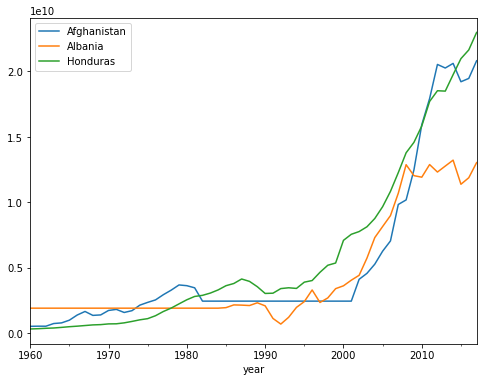

In [78]:
# plot the results
plot_results('GDP_bfill')

## Conclusion 

In this case, the GDP data for all three countries is now complete. Note that forward fill did not fill all the Albania data because the first data entry in 1960 was NaN. Forward fill would try to fill the 1961 value with the NaN value from 1960.

To completely fill the entire GDP data for all countries, you might have to run both forward fill and back fill. Note as well that the results will be slightly different depending on if you run forward fill first or back fill first. Afghanistan, for example, is missing data in the middle of the data set. Hence forward fill and back fill will have slightly different results.

Run this next code cell to see if running both forward fill and back fill end up filling all the GDP NaN values.

In [79]:
# Run forward fill and backward fill on the GDP data
df_melt['GDP_ff_bf'] = df_melt.sort_values('year').groupby('Country Name')['GDP'].fillna(method='ffill').fillna(method='bfill')

# Check if any GDP values are null
df_melt['GDP_ff_bf'].isnull().sum()

0